In [67]:
import h5py
import time
import torch
import pyreadr
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pandas.api.types import CategoricalDtype
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import weight_norm
from sklearn.manifold import TSNE
from livelossplot import PlotLosses
from pytorch_model_summary import summary
from tqdm.notebook import tqdm, trange

device = torch.device('cuda')

In [68]:
from joblib import dump, load
from sklearn import metrics
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [69]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [70]:
# class TCN(nn.Module):
#     def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
#         super(TCN, self).__init__()
#         self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
#         self.linear = nn.Linear(num_channels[-1], output_size)

#     def forward(self, inputs):
#         """Inputs have to have dimension (N, C_in, L_in)"""
#         y1 = self.tcn(inputs)  # input should have dimension (N, C, L)
#         pred = self.linear(y1[:, :, -1])
#         return pred

In [71]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, w, m, y, df_id, idx):
        self.w = w
        self.m = m
        self.y = y
        self.idx = idx
        self.df_id = df_id
            
    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
            
        idx = self.idx[idx]
        widx = self.df_id.widx.values[idx]
        
        ww = torch.tensor(self.w[(widx - 90):(widx + 210)], dtype=torch.float, device = device)
        dd = torch.arange(300, dtype=torch.float, device = device).reshape(1,-1)/300 - 0.5
        ww = torch.cat([ww.t(), dd], 0)
        mm = torch.tensor(self.m[idx], dtype=torch.float, device = device)
        yy = torch.tensor(self.y[idx], dtype=torch.float, device = device)
        
        return (ww, mm, yy)

In [72]:
class MyNet(nn.Module):

    def __init__(self, w_layers, pred_layers, d):

        super().__init__()
              
        # Weaher variables
#         w_layers_list = nn.ModuleList()
#         for i, o, k, d in w_layers:
#             w_layer = nn.Sequential(
#                 nn.Conv1d(i, o, k, stride=2),
#                 nn.LeakyReLU(),
#                 nn.BatchNorm1d(o),
#                 nn.Dropout(d)
#             )
#             w_layers_list.append(w_layer)
#         w_layers_list.append(nn.AdaptiveAvgPool1d(1))
#         self.w_layers = nn.Sequential(*w_layers_list)
        self.tcn = TemporalConvNet(w_layers[0], w_layers[1:-1], kernel_size=3, dropout=d)
        self.linear = nn.Linear(w_layers[-2], w_layers[-1])


        # Management variables
        pred_layers_list = nn.ModuleList()
        for i, o, d in pred_layers:
            pred_layer = nn.Sequential(
                nn.Linear(i, o),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            pred_layers_list.append(pred_layer)
        pred_layers_list.append(nn.Linear(o, 1))
        self.pred_layers = nn.Sequential(*pred_layers_list)
        
   
    def forward(self, Ws, Ms):
        
#         W_feat = self.w_layers(Ws).view(Ws.shape[0], -1)
        W_feat = self.tcn(Ws)
        W_feat = self.linear(W_feat[:, :, -1])
        all_feats = torch.cat([W_feat, Ms], dim = 1)
        pred = self.pred_layers(all_feats)
        return (pred)


In [73]:
data_file = '/home/rodrigo7/Documents/APSIMDL/data/train.h5'
yield_file = '/home/rodrigo7/Apsim_test/MASAGRO/MASAGRO.csv'
met_file = '/home/rodrigo7/Apsim_test/MASAGRO/Daymet/CH00006.met'

In [74]:
w = pd.read_csv(met_file, skiprows=11, sep=' ')
w.columns = pd.read_csv(met_file, skiprows=10, sep=' ').columns
w['date'] = pd.to_datetime(w.year * 1000 + w.day, format='%Y%j')
w = w.reset_index()
W = w.iloc[:,3:8]
W_std = StandardScaler().fit(W)
W = W_std.transform(W)
# dump(W_std, '../data/W_std.bin', compress=True)
print(W.shape)

(14245, 5)


In [75]:
ydf = pd.read_csv(yield_file)
ydf['day_sow'] = pd.to_datetime(pd.to_datetime(ydf['Maize.SowingDate']).dt.date)
ydf['widx'] = ydf.merge(w, left_on='day_sow', right_on = 'date')['index']
ydf = ydf.loc[ydf.Yield > 5500]
sim_namedf = ydf.SimulationID.str.split(pat = '_', expand=True)
ydf['n_rate'] = sim_namedf[2]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bd8791a90>]],
      dtype=object)

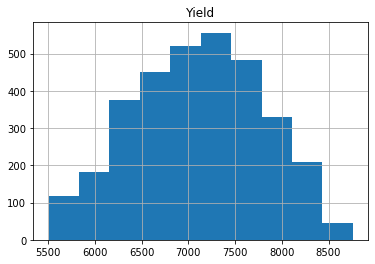

In [76]:
ydf.hist('Yield')

In [77]:
Y_data = ydf.Yield.values.reshape(-1,1)
Y_std = StandardScaler().fit(Y_data)
Y = Y_std.transform(Y_data)
# dump(Y_std, '../data/Y_std.bin', compress=True)
print(Y.shape)

(3269, 1)


In [78]:
M_data = ydf.loc[:,'n_rate'].values.reshape(-1,1)
M_std = StandardScaler().fit(M_data)
M = M_std.transform(M_data)
# dump(M_std, '../data/M_std.bin', compress=True)
print(M.shape)

(3269, 1)


In [79]:
Z = ydf.day_sow.dt.year.values.reshape(-1,1)
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, train_size= 0.9, random_state=123456)
xidx = np.arange(len(ydf))
train_idx, val_idx = next(gss.split(xidx, groups=Z))
train_idx.size, val_idx.size

(2944, 325)

In [80]:
ntrain_idx = np.random.choice(train_idx, size=train_idx.size, replace=False)
nval_idx = np.random.choice(val_idx, size=val_idx.size, replace=False)
ntrain_idx.size, nval_idx.size

(2944, 325)

In [81]:
len(np.unique(Z[ntrain_idx])), len(np.unique(Z[nval_idx])),

(34, 4)

In [82]:
batch_size = 1000


pred_dataset = MyDataset(W, M, Y, ydf, xidx)
train_dataset = MyDataset(W, M, Y, ydf, ntrain_idx)
val_dataset = MyDataset(W, M, Y, ydf, nval_idx)


pred_loader = DataLoader(pred_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=False, shuffle=True)

data_inputs = iter(train_loader).next()
print(len(train_loader))



3


In [89]:
d = 0.1
w_layers = [6, 8, 8, 8, 8, 8, 8, 10]
pred_layers = [[11,25,d],[25,25,d], [25,25,d]]

model = MyNet(w_layers, pred_layers, d)
model = model.to(device)
# model.load_state_dict(torch.load('../data/model_vn.pth', map_location=device))
sm = summary(model, *data_inputs[:2], print_summary=True,  max_depth=2)

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
   TemporalBlock-1      [1000, 8, 300]             424             424
   TemporalBlock-2      [1000, 8, 300]             416             416
   TemporalBlock-3      [1000, 8, 300]             416             416
   TemporalBlock-4      [1000, 8, 300]             416             416
   TemporalBlock-5      [1000, 8, 300]             416             416
   TemporalBlock-6      [1000, 8, 300]             416             416
          Linear-7          [1000, 10]              90              90
          Linear-8          [1000, 25]             300             300
       LeakyReLU-9          [1000, 25]               0               0
    BatchNorm1d-10          [1000, 25]              50              50
        Dropout-11          [1000, 25]               0               0
         Linear-12          [1000, 25]             650             650
     

In [90]:
# d = 0.1
# input_channels = 6
# kernel_size = 7
# n_classes = 1


# w_layers = [6, 8, 8, 8, 8, 10]
# pred_layers = [[11,25,d],[25,25,d], [25,25,d]]

# model = MyNet(w_layers, pred_layers, d)

# model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=d)
# self.tcn = TemporalConvNet(w_layers[0], w_layers[1:], kernel_size=3, dropout=d)
# class TCN(nn.Module):
#     def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
#         super(TCN, self).__init__()
#         self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
# sm = summary(model, *data_inputs[:2], print_summary=True, max_depth=10)

In [91]:
# d = 0.1
# w_layers =  [[6,12,3,d],[12,12,5,d],[12,12,7,d],[12,12,5,d],[12,10,3,d]]
# pred_layers = [[11,25,d],[25,25,d], [25,25,d]]

# model = MyNet(w_layers, pred_layers)
# model = model.to(device)
# model.load_state_dict(torch.load('../data/model_vn.pth', map_location=device))
# sm = summary(model, *data_inputs[:2], print_summary=True)

In [92]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

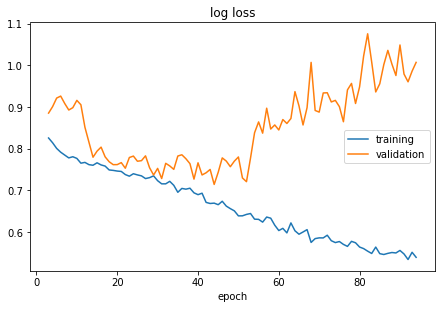

log loss:
training   (min:    0.534, max:    1.119, cur:    0.539)
validation (min:    0.714, max:    1.076, cur:    1.007)
[50:93] loss: 0.539 time:1.42


In [93]:
min_loss = 10
bad_epochs = 0
liveloss = PlotLosses()
num_epochs = 150 # Define o número de épocas para realizar o treinamento 
for epoch in range(num_epochs):
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for i, (Ws, Ms, Ys) in enumerate(tqdm(train_loader)):
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
        outputs = model(Ws, Ms)

        # Caulcula a perda pela loss function
        loss = criterion(outputs, Ys)

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        epoch_loss.append(loss.data.item())
        
    model.eval()
    for i, (Ws, Ms, Ys) in enumerate(tqdm(val_loader)):
        with torch.no_grad():
          # Obtem o output
          outputs = model(Ws, Ms)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, Ys)

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    if val_loss < min_loss:
        # Nome da pasta com o arquivo .pth salvando os pesos do modelo treinado
        model_file_name = '../data/model_vn.pth'
        torch.save(model.state_dict(), model_file_name)
        bad_epochs = 0
        min_loss = val_loss
    else:
        bad_epochs += 1
    
    if bad_epochs > 50:
        break

    liveloss.update({
        'log loss': epoch_loss,
        'val_log loss': val_loss
    })
    liveloss.draw() #Apresenta o gráfico log loss
    print('[%d:%d] loss: %.3f time:%.2f' % (bad_epochs, epoch, epoch_loss, time_taken))


In [94]:
model.load_state_dict(torch.load('../data/model_vn.pth', map_location=device))
print('Model OK')

Model OK


In [95]:
# Inicia o tempo para contagem
start_time = time.time()

# Realiza a predição dos dados a partir do modelo treinado - Dados de validação
model.eval()
obs = []
preds = []
for i, (Ws, Ms, Ys) in enumerate(tqdm(val_loader)):
    obs.append(Ys.cpu().data.numpy())
    with torch.no_grad():
        pred = model(Ws, Ms)
    preds.append(pred.cpu().data.numpy())
obs = np.concatenate(obs)
preds = np.concatenate(preds)

# Faz a diferença para calcular o tempo           
time_taken = time.time() - start_time
# Apresenta o valor do tempo
print('time:%.2f' % (time_taken))


time:0.13


0.49


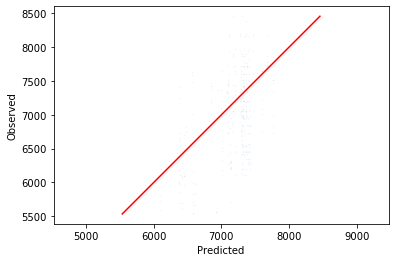

In [96]:
x = Y_std.inverse_transform(preds.reshape(-1))
y = Y_std.inverse_transform(obs.reshape(-1))

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, 0.1, alpha=0.1)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3))
plt.show()

In [55]:
# model.eval()
# b_loss = []
# for (Ws, Ss, Ms, Ys) in tqdm(train_loader):
#     w_loss = []
#     for i in trange(300):
#         v_loss = [i]
#         for v in range(5):
#             Wsw = Ws.clone()
#             Wsw[:,v,(i-4):(i+3)] = 0
#             with torch.no_grad():
#                 outputs = model(Wsw, Ss, Ms)
#             loss = criterion(outputs, Ys)
#             v_loss.append(loss.data.item())
#         w_loss.append(v_loss)
#     b_loss.append(np.array(w_loss))

In [ ]:
dap_err = np.stack(b_loss).mean(0)

In [ ]:
cls = ["interval","radn", "maxt", "mint", "rain", "dayl", "dap"]


In [ ]:
plt.figure(figsize=(20,10))
for i in range(1,6):
    plt.plot(dap_err.T[0], dap_err.T[i], label = cls[i])
plt.legend()


In [ ]:
x = Y_std.inverse_transform(preds.reshape(-1))
y = Y_std.inverse_transform(obs.reshape(-1))

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, 0.1, alpha=0.1)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3))
plt.show()

In [ ]:
x.mean(), y.mean()